# CNN Image Classification Laboration


Images used in this laboration are from CIFAR 10 (https://en.wikipedia.org/wiki/CIFAR-10). The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. Your task is to make a classifier, using a convolutional neural network, that can correctly classify each image into the correct class.

You need to answer all questions in this notebook. 

## Part 1: What is a convolution

To understand a bit more about convolutions, we will first test the convolution function in scipy using a number of classical filters. 

Convolve the image with Gaussian filter, a Sobel X filter, and a Sobel Y filter, using the function 'convolve2d' in 'signal' from scipy.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html

In a CNN, many filters are applied in each layer, and the filter coefficients are learned through back propagation (which is in contrast to traditional image processing, where the filters are designed by an expert).

In [124]:
# This cell is finished

from scipy import signal
import numpy as np

# Get a test image
from scipy import misc
image = misc.ascent()

# Define a help function for creating a Gaussia/opt/liu/course-venv-732a78/1.n filter
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

# Create Gaussian filter with certain size and standard deviation
gaussFilter = matlab_style_gauss2D((15,15),4)

# Define filter kernels for SobelX and Sobely
sobelX = np.array([[ 1, 0,  -1],
                    [2, 0, -2],
                    [1, 0, -1]]) 

sobelY = np.array([[ 1, 2,  1],
                    [0, 0, 0],
                    [-1, -2, -1]]) 

In [125]:
# Perform convolution using the function 'convolve2d' for the different filters
filterResponseGauss = signal.convolve2d(image, gaussFilter)
filterResponseSobelX = signal.convolve2d(image, sobelX)
filterResponseSobelY = signal.convolve2d(image, sobelY)

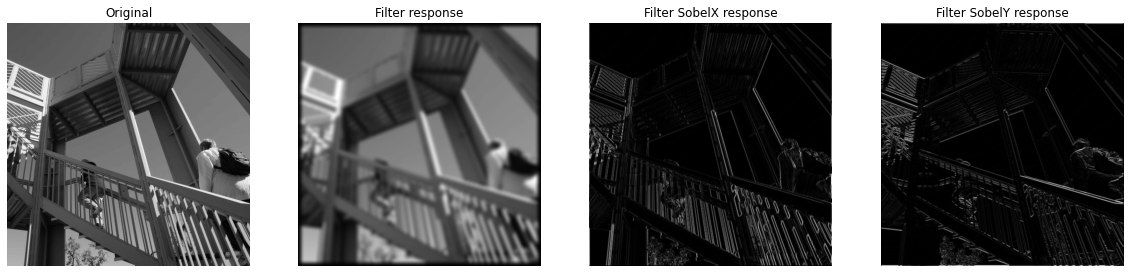

In [126]:
import matplotlib.pyplot as plt

# Show filter responses
fig, (ax_orig, ax_filt1, ax_filt2, ax_filt3) = plt.subplots(1, 4, figsize=(20, 6))
ax_orig.imshow(image, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_filt1.imshow(np.absolute(filterResponseGauss), cmap='gray')
ax_filt1.set_title('Filter response')
ax_filt1.set_axis_off()
ax_filt2.imshow(np.absolute(filterResponseSobelX), cmap='gray')
ax_filt2.set_title('Filter SobelX response')
ax_filt2.set_axis_off()
ax_filt3.imshow(np.absolute(filterResponseSobelY), cmap='gray')
ax_filt3.set_title('Filter SobelY response')
ax_filt3.set_axis_off()

##  Part 2: Understanding convolutions

Question 1: What do the 3 different filters (Gaussian, SobelX, SobelY) do to the original image?

Question 2: What is the size of the original image? How many channels does it have? How many channels does a color image normally have?

Question 3: What is the size of the different filters?

Question 4: What is the size of the filter response if mode 'same' is used for the convolution ?

Question 5: What is the size of the filter response if mode 'valid' is used for the convolution? How does the size of the valid filter response depend on the size of the filter? 

Question 6: Why are 'valid' convolutions a problem for CNNs with many layers?


Q1: The gaussian filter is used to blur images and remove detail and noise. It outputs a weighted average of each pixel neighboorhod, with the average weighted more towards the value of the central pixels. It thereby provides a smoothing to the image but still preserves edges.
The sobel filters detect edges, i.e pixels where there is a strong contrasts. SobelX apply filter in horizontal axis, while SobelY apply in the vertical axis. 

Q3: SobelY & SobelX are 3x3 filters. Gaussian filter is 15x15.

Q6: Hinted by the name, valid mode only uses valid input data - meaning it won't include padding. This may cause the filter to drop/skip pixels if the input dimension doesn't fit the size of the filter. Doing this repeatedly in many layers may therefor cause us to disregard/lose to many pixels which would result in poor performance.

In [127]:
# Your code for checking sizes of image and filter responses
# Q2
print(image.shape)
# Grayscale image has 1 channel.
# Color images normally have 3 channels (red, green, blue)

# Q4
filterResponseSobelY_same = signal.convolve2d(image, sobelY, mode="same").shape
print(filterResponseSobelY_same)

# Q5
filterResponseSobelY_valid = signal.convolve2d(image, sobelY, mode="valid").shape
print(filterResponseSobelY_valid)
# If 'valid' mode is used, filter response has size (l1-l2+1, w1-w2+1), where l1, l2, w1, w2 are 
# lengths and widths of input image and filter respectively.
# As we can see, the size of response depends on both the size of the image and the size of the filter.

(512, 512)
(512, 512)
(510, 510)


##  Part 3: Get a graphics card

Skip this part if you run on a CPU (recommended)

Let's make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming convolutions in every training iteration.

In [ ]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

##  Part 4: How fast is the graphics card?

Question 7: Why are the filters used for a color image of size 7 x 7 x 3, and not 7 x 7 ? 

Question 8: What operation is performed by the 'Conv2D' layer? Is it a standard 2D convolution, as performed by the function signal.convolve2d we just tested?

Question 9: Do you think that a graphics card, compared to the CPU, is equally faster for convolving a batch of 1,000 images, compared to convolving a batch of 3 images? Motivate your answer.

Q7: Because we have 3 color channels which we also want to regard.

Q8: Conv2D layer provides a transformation from input data into a feature map by applying an operation of convoloution. Scipy(signal) inverts the kernel before applying the convoloution which tensorflow(Conv2D) does not.

Q9: No, as that small amount of data is not enough to operate the graphics card with it's full potential but rather it's ineffective to process that small amount on a graphics card.

##  Part 5:  Load data
Time to make a 2D CNN. Load the images and labels from keras.datasets, this cell is already finished.

In [128]:
from keras.datasets import cifar10
import numpy as np

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Download CIFAR train and test data
(Xtrain, Ytrain), (Xtest, Ytest) = cifar10.load_data()

print("Training images have size {} and labels have size {} ".format(Xtrain.shape, Ytrain.shape))
print("Test images have size {} and labels have size {} \n ".format(Xtest.shape, Ytest.shape))

# Reduce the number of images for training and testing to 10000 and 2000 respectively, 
# to reduce processing time for this laboration
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

Xtest = Xtest[0:2000]
Ytest = Ytest[0:2000]

Ytestint = Ytest

print("Reduced training images have size %s and labels have size %s " % (Xtrain.shape, Ytrain.shape))
print("Reduced test images have size %s and labels have size %s \n" % (Xtest.shape, Ytest.shape))

# Check that we have some training examples from each class
for i in range(10):
    print("Number of training examples for class {} is {}" .format(i,np.sum(Ytrain == i)))

Training images have size (50000, 32, 32, 3) and labels have size (50000, 1) 
Test images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
 
Reduced training images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
Reduced test images have size (2000, 32, 32, 3) and labels have size (2000, 1) 

Number of training examples for class 0 is 1005
Number of training examples for class 1 is 974
Number of training examples for class 2 is 1032
Number of training examples for class 3 is 1016
Number of training examples for class 4 is 999
Number of training examples for class 5 is 937
Number of training examples for class 6 is 1030
Number of training examples for class 7 is 1001
Number of training examples for class 8 is 1025
Number of training examples for class 9 is 981


##  Part 6: Plotting

Lets look at some of the training examples, this cell is already finished. You will see different examples every time you run the cell.

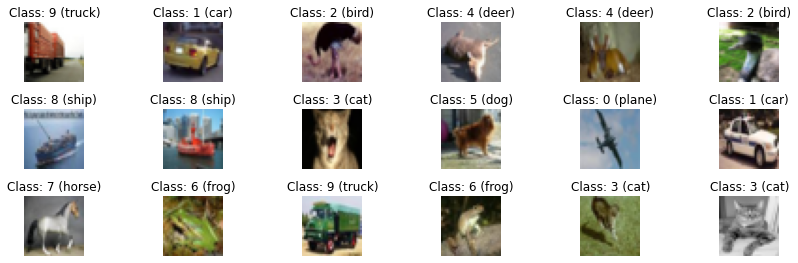

In [129]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for i in range(18):
    idx = np.random.randint(7500)
    label = Ytrain[idx,0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(Xtrain[idx])
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

##   Part 7: Split data into training, validation and testing
Split your training data into training (Xtrain, Ytrain) and validation (Xval, Yval), so that we have training, validation and test datasets (as in the previous laboration). We use a function in scikit learn. Use 25% of the data for validation.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [130]:
from sklearn.model_selection import train_test_split

Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, train_size=0.75, random_state=42)


#Xtrain, Xtemp = train_test_split(X, train_size = 0.70, random_state=42)
#Ytrain, Ytemp = train_test_split(Y, train_size = 0.70, random_state=42)

print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xval has size {}.'.format(Xval.shape))
print('Yval has size {}.'.format(Yval.shape))

# Print the size of training data, validation data and test data


Xtrain has size (7500, 32, 32, 3).
Ytrain has size (7500, 1).
Xval has size (2500, 32, 32, 3).
Yval has size (2500, 1).


##  Part 8: Preprocessing of images

Lets perform some preprocessing. The images are stored as uint8, i.e. 8 bit unsigned integers, but need to be converted to 32 bit floats. We also make sure that the range is -1 to 1, instead of 0 - 255. This cell is already finished.

In [131]:
# Convert datatype for Xtrain, Xval, Xtest, to float32
Xtrain = Xtrain.astype('float32')
Xval = Xval.astype('float32')
Xtest = Xtest.astype('float32')

# Change range of pixel values to [-1,1]
Xtrain = Xtrain / 127.5 - 1
Xval = Xval / 127.5 - 1
Xtest = Xtest / 127.5 - 1

##  Part 9: Preprocessing of labels

The labels (Y) need to be converted from e.g. '4' to "hot encoded", i.e. to a vector of type [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] . We use a function in Keras, see https://keras.io/api/utils/python_utils/#to_categorical-function

In [132]:
from tensorflow.keras.utils import to_categorical

# Print shapes before converting the labels
print(Ytrain.shape)
print(Yval.shape)
print(Ytest.shape)

# Your code for converting Ytrain, Yval, Ytest to categorical
Ytrain = to_categorical(Ytrain, num_classes=len(classes), dtype="float32")
Yval = to_categorical(Yval, num_classes=len(classes), dtype="float32")
Ytest = to_categorical(Ytest, num_classes=len(classes), dtype="float32")
# Print shapes after converting the labels
print(Ytrain.shape)
print(Yval.shape)
print(Ytest.shape)


(7500, 1)
(2500, 1)
(2000, 1)
(7500, 10)
(2500, 10)
(2000, 10)


##  Part 10: 2D CNN
Finish this code to create the image classifier, using a 2D CNN. Each convolutional layer will contain 2D convolution, batch normalization and max pooling. After the convolutional layers comes a flatten layer and a number of intermediate dense layers. The convolutional layers should take the number of filters as an argument, use a kernel size of 3 x 3, 'same' padding, and relu activation functions. The number of filters will double with each convolutional layer. The max pooling layers should have a pool size of 2 x 2. The intermediate dense layers before the final dense layer should take the number of nodes as an argument, use relu activation functions, and be followed by batch normalization. The final dense layer should have 10 nodes (= the number of classes in this laboration) and 'softmax' activation. Here we start with the Adam optimizer.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`Conv2D()`, performs 2D convolutions with a number of filters with a certain size (e.g. 3 x 3). 

`BatchNormalization()`, perform batch normalization

`MaxPooling2D()`, saves the max for a given pool size, results in down sampling

`Flatten()`, flatten a multi-channel tensor into a long vector

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/api/layers/core_layers/dense/ and https://keras.io/api/layers/reshaping_layers/flatten/ for information on how the `Dense()` and `Flatten()` functions work

See https://keras.io/layers/convolutional/ for information on how `Conv2D()` works

See https://keras.io/layers/pooling/ for information on how `MaxPooling2D()` works

Import a relevant cost function for multi-class classification from keras.losses (https://keras.io/losses/)

See the following links for how to compile, train and evaluate the model

https://keras.io/api/models/model_training_apis/#compile-method

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method

Each convolutional layer will contain 2D convolution, batch normalization and max pooling. After the convolutional layers comes a flatten layer and a number of intermediate dense layers. 

* The convolutional layers should take the number of filters as an argument, use a kernel size of 3 x 3, 'same' padding, and relu activation functions. The number of filters will double with each convolutional layer. 

* The max pooling layers should have a pool size of 2 x 2.

* The intermediate dense layers before the final dense layer should take the number of nodes as an argument, use relu activation functions, and be followed by batch normalization. 

The final dense layer should have 10 nodes (= the number of classes in this laboration) and 'softmax' activation. Here we start with the Adam optimizer.

In [133]:
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)



def build_CNN(input_shape, n_conv_layers=2, n_filters=16, n_dense_layers=0, n_nodes=50, use_dropout=False, learning_rate=0.01):

    # Setup a sequential model
    model = Sequential()

    # Add first convolutional layer to the model, requires input shape
    model.add(Conv2D(filters = n_filters, kernel_size=(3, 3), activation='relu', 
                     input_shape= input_shape, padding="same"))
    
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    # Add remaining convolutional layers to the model, the number of filters should increase a factor 2 for each layer
    for i in range(n_conv_layers-1):
        n_filters = n_filters *2 # update n_filters first
        model.add(Conv2D(filters = n_filters, kernel_size=(3, 3), activation='relu', padding="same"))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (2, 2)))
        
    
    # Add flatten layer
    model.add(Flatten())
    # Add intermediate dense layers
    for i in range(n_dense_layers):
        model.add(Dense(units=n_nodes, activation = 'relu'))
        model.add(BatchNormalization())

        if use_dropout:
            model.add(Dropout(rate=0.5))
    # Add final dense layer
    model.add(Dense(10,activation='softmax'))
   
    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [134]:
# Lets define a help function for plotting the training results
import matplotlib.pyplot as plt
def plot_results(history):
    
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

## Part 11: Train 2D CNN

Time to train the 2D CNN, start with 2 convolutional layers, no intermediate dense layers, learning rate = 0.01. The first convolutional layer should have 16 filters (which means that the second convolutional layer will have 32 filters).

Relevant functions

`build_CNN`, the function we defined in Part 10, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See the following links for how to train and evaluate the model

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method

## 2 convolutional layers, no intermediate dense layers

In [135]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:]

# Build model
model1 = build_CNN(input_shape)

# Train the model  using training data and validation data
history1 = model1.fit(Xtrain, Ytrain, validation_data = (Xval, Yval), epochs= epochs, batch_size = batch_size)

Epoch 1/20
75/75 [==============================] - 3s 34ms/step - loss: 1.9475 - accuracy: 0.3513 - val_loss: 2.0126 - val_accuracy: 0.3428
Epoch 2/20
75/75 [==============================] - 2s 29ms/step - loss: 1.4632 - accuracy: 0.4839 - val_loss: 1.8609 - val_accuracy: 0.3640
Epoch 3/20
75/75 [==============================] - 2s 28ms/step - loss: 1.2781 - accuracy: 0.5459 - val_loss: 1.6993 - val_accuracy: 0.3952
Epoch 4/20
75/75 [==============================] - 2s 25ms/step - loss: 1.1392 - accuracy: 0.6004 - val_loss: 1.5413 - val_accuracy: 0.4400
Epoch 5/20
75/75 [==============================] - 2s 26ms/step - loss: 1.0175 - accuracy: 0.6487 - val_loss: 1.4084 - val_accuracy: 0.4976
Epoch 6/20
75/75 [==============================] - 2s 27ms/step - loss: 0.9127 - accuracy: 0.6775 - val_loss: 1.3353 - val_accuracy: 0.5340
Epoch 7/20
75/75 [==============================] - 2s 27ms/step - loss: 0.8172 - accuracy: 0.7145 - val_loss: 1.2989 - val_accuracy: 0.5504
Epoch 8/20
75

In [136]:
# Evaluate the trained model on test set, not used in training or validation
score = model1.evaluate(Xtest, Ytest)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

63/63 [==============================] - 0s 5ms/step - loss: 1.8634 - accuracy: 0.5575
Test loss: 1.8634
Test accuracy: 0.5575


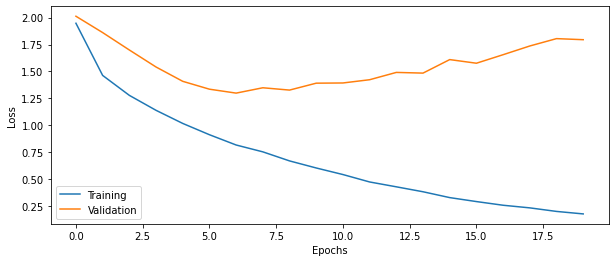

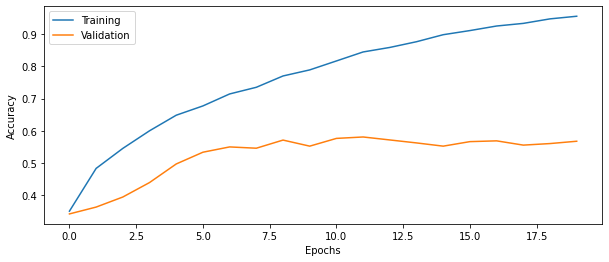

In [137]:
# Plot the history from the training run
plot_results(history1)

## Part 12: Improving performance

Write down the test accuracy, are you satisfied with the classifier performance (random chance is 10%) ? 

Question 10: How big is the difference between training and test accuracy?

Question 11: For the DNN laboration we used a batch size of 10,000, why do we need to use a smaller batch size in this laboration?

Test accuracy: 0.5495

Q10: 0.9413 - 0.5495 = 0.3918 = 38%

Q11: The CNN aims to learning spatial features of the image by different layers. As batch size controls how often we update our weights, with too large batch size we won't be able to make any adjustments to smaller features. 

## 2 convolutional layers, 1 intermediate dense layer (50 nodes)

In [138]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:]

# Build model
model2 = build_CNN(input_shape, n_dense_layers=1)

# Train the model  using training data and validation data
history2 = model2.fit(Xtrain, Ytrain, validation_data = (Xval, Yval), epochs= epochs, batch_size = batch_size)

Epoch 1/20
75/75 [==============================] - 3s 33ms/step - loss: 1.7595 - accuracy: 0.3787 - val_loss: 2.2113 - val_accuracy: 0.1920
Epoch 2/20
75/75 [==============================] - 2s 29ms/step - loss: 1.2884 - accuracy: 0.5465 - val_loss: 2.4729 - val_accuracy: 0.1608
Epoch 3/20
75/75 [==============================] - 2s 32ms/step - loss: 1.0470 - accuracy: 0.6361 - val_loss: 2.5097 - val_accuracy: 0.1900
Epoch 4/20
75/75 [==============================] - 2s 30ms/step - loss: 0.8414 - accuracy: 0.7213 - val_loss: 2.3012 - val_accuracy: 0.2500
Epoch 5/20
75/75 [==============================] - 2s 31ms/step - loss: 0.6714 - accuracy: 0.7916 - val_loss: 1.8830 - val_accuracy: 0.3484
Epoch 6/20
75/75 [==============================] - 2s 29ms/step - loss: 0.5165 - accuracy: 0.8528 - val_loss: 1.6815 - val_accuracy: 0.4252
Epoch 7/20
75/75 [==============================] - 2s 29ms/step - loss: 0.3789 - accuracy: 0.9040 - val_loss: 1.4233 - val_accuracy: 0.5244
Epoch 8/20
75

In [139]:
# Evaluate the trained model on test set, not used in training or validation
score = model2.evaluate(Xtest, Ytest)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

63/63 [==============================] - 1s 6ms/step - loss: 1.9535 - accuracy: 0.5455
Test loss: 1.9535
Test accuracy: 0.5455


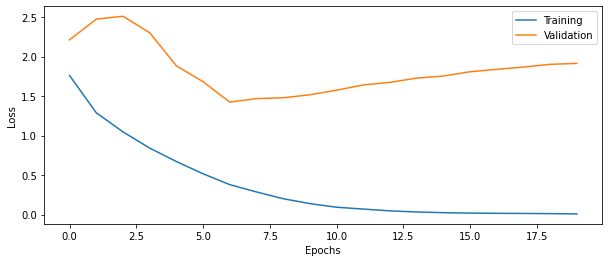

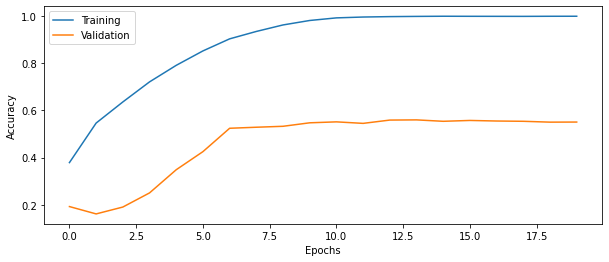

In [140]:
# Plot the history from the training run
plot_results(history2)

## 4 convolutional layers, 1 intermediate dense layer (50 nodes)

In [141]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:]

# Build model
model3 = build_CNN(input_shape, n_dense_layers=1, n_conv_layers=4)

# Train the model  using training data and validation data
history3 = model3.fit(Xtrain, Ytrain, validation_data = (Xval, Yval), epochs= epochs, batch_size = batch_size)

Epoch 1/20
75/75 [==============================] - 4s 45ms/step - loss: 1.7416 - accuracy: 0.3967 - val_loss: 2.5147 - val_accuracy: 0.1528
Epoch 2/20
75/75 [==============================] - 3s 38ms/step - loss: 1.2432 - accuracy: 0.5640 - val_loss: 2.7017 - val_accuracy: 0.2004
Epoch 3/20
75/75 [==============================] - 3s 43ms/step - loss: 1.0007 - accuracy: 0.6565 - val_loss: 2.5263 - val_accuracy: 0.2328
Epoch 4/20
75/75 [==============================] - 3s 39ms/step - loss: 0.7791 - accuracy: 0.7449 - val_loss: 2.0946 - val_accuracy: 0.3084
Epoch 5/20
75/75 [==============================] - 3s 40ms/step - loss: 0.5772 - accuracy: 0.8177 - val_loss: 1.9178 - val_accuracy: 0.3788
Epoch 6/20
75/75 [==============================] - 3s 40ms/step - loss: 0.4028 - accuracy: 0.8868 - val_loss: 1.4520 - val_accuracy: 0.5024
Epoch 7/20
75/75 [==============================] - 3s 41ms/step - loss: 0.2721 - accuracy: 0.9335 - val_loss: 1.4831 - val_accuracy: 0.5200
Epoch 8/20
75

In [142]:
# Evaluate the trained model on test set, not used in training or validation
score = model3.evaluate(Xtest, Ytest)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

63/63 [==============================] - 1s 7ms/step - loss: 1.9133 - accuracy: 0.5400
Test loss: 1.9133
Test accuracy: 0.5400


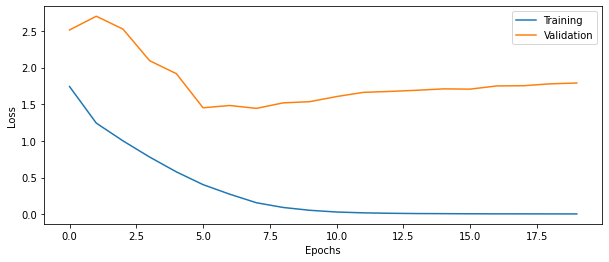

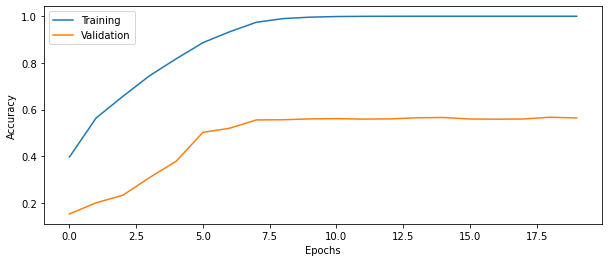

In [143]:
# Plot the history from the training run
plot_results(history3)

##  Part 13: Plot the CNN architecture

To understand your network better, print the architecture using `model.summary()`

Question 12: How many trainable parameters does your network have? Which part of the network contains most of the parameters?

Question 13: What is the input to and output of a Conv2D layer? What are the dimensions of the input and output? 

Question 14: Is the batch size always the first dimension of each 4D tensor? Check the documentation for Conv2D, https://keras.io/layers/convolutional/

Question 15: If a convolutional layer that contains 128 filters is applied to an input with 32 channels, what is the number of channels in the output?

Question 16: Why is the number of parameters in each Conv2D layer *not* equal to the number of filters times the number of filter coefficients per filter (plus biases)?

Question 17: How does MaxPooling help in reducing the number of parameters to train?

Q12: Trainable params: 124,180.  conv2d_31 (Conv2D)          (None, 4, 4, 128)         73856 

Q13: The input shape is (n_images, x_dimension, y_dimension, n_channels) - but keras ignores the first dimension as the model should be able to deal with any batch size. 

The output is a 4+D tensor representing activation(conv2d(inputs, kernell)+bias)

The dimensions of the input shape have the dimensions of the previous output layer. The output is halfing the image shape (e.g from 32x32 to 16x16) and doubbling the number of channels (e.g from 16 to 32).
I.e: dimensions = (None, x_dimension/2, y_dimension/2, n_channels*2)

Q14: Yes.

Q15: Number of channels is equal to the number of filters.

Q16: Because we have to regard the linear combination of the output from the input layer.
The number of parameters for each convolution layer is equal to: 
n_filters * n_coefficients * n_input_channels + biases. This is because it has 
separate coefficients for each input channel.


Q17: It reduces the number of pixels in the output from the previous layer, which helps reducing the dimensionality of the image and as such the number of parameters to train. Although it does not impact the number of parameters for the next convolution layer, 
it does have a great effect on the
output size of the flatten layer, which reduces the number of parameters for the subsequent dense layers.


In [144]:
# Print network architecture

model3.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_89 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 batch_normalization_99 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_89 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_90 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 batch_normalization_100 (Ba  (None, 16, 16, 32)       128       
 tchNormalization)                                               
                                                     

##  Part 14: Dropout regularization

Add dropout regularization to each intermediate dense layer, dropout probability 50%.

Question 18: How much did the test accuracy improve with dropout, compared to without dropout?

Question 19: What other types of regularization can be applied? How can you add L2 regularization for the convolutional layers?


Q18: With dropout: Test accuracy: 0.5890
W/o dropout: Test accuracy: 0.5670.
So roughly 2%

Q19: Some other regularization techniques we may use is for instance data augmentation (e.g rotating pictures) or early stopping. We add L2 regularization with the argument kernel_regularizer=l2, which takes one argument which is the regularization factor. The regularization factor is applied to each weight and encourages the model to only add relevant parameters to the model.

## 4 convolutional layers, 1 intermediate dense layer (50 nodes), dropout

In [145]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:]

# Build model
model4 = build_CNN(input_shape, n_dense_layers=1, n_conv_layers=4, use_dropout=False)

# Train the model  using training data and validation data
history4 = model4.fit(Xtrain, Ytrain, validation_data = (Xval, Yval), epochs= epochs, batch_size = batch_size)

Epoch 1/20
75/75 [==============================] - 4s 43ms/step - loss: 1.7418 - accuracy: 0.3873 - val_loss: 2.4239 - val_accuracy: 0.1128
Epoch 2/20
75/75 [==============================] - 3s 41ms/step - loss: 1.2716 - accuracy: 0.5472 - val_loss: 2.7082 - val_accuracy: 0.1252
Epoch 3/20
75/75 [==============================] - 3s 41ms/step - loss: 1.0356 - accuracy: 0.6340 - val_loss: 2.5292 - val_accuracy: 0.1944
Epoch 4/20
75/75 [==============================] - 3s 39ms/step - loss: 0.8102 - accuracy: 0.7253 - val_loss: 2.0069 - val_accuracy: 0.2872
Epoch 5/20
75/75 [==============================] - 3s 42ms/step - loss: 0.5954 - accuracy: 0.8121 - val_loss: 1.6250 - val_accuracy: 0.4292
Epoch 6/20
75/75 [==============================] - 3s 39ms/step - loss: 0.4053 - accuracy: 0.8880 - val_loss: 1.3876 - val_accuracy: 0.5236
Epoch 7/20
75/75 [==============================] - 3s 40ms/step - loss: 0.2597 - accuracy: 0.9365 - val_loss: 1.4634 - val_accuracy: 0.5304
Epoch 8/20
75

In [146]:
# Evaluate the trained model on test set, not used in training or validation
score = model4.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

63/63 [==============================] - 1s 7ms/step - loss: 1.8228 - accuracy: 0.5555
Test loss: 1.8228
Test accuracy: 0.5555


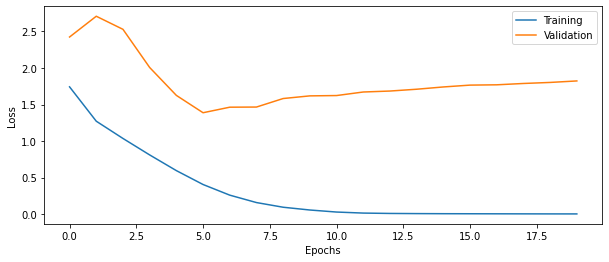

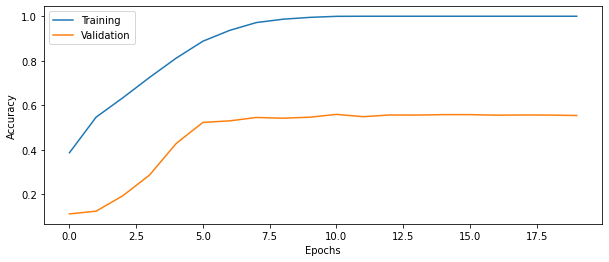

In [147]:
# Plot the history from the training run
plot_results(history4)

##  Part 15: Tweaking performance

You have now seen the basic building blocks of a 2D CNN. To further improve performance involves changing the number of convolutional layers, the number of filters per layer, the number of intermediate dense layers, the number of nodes in the intermediate dense layers, batch size, learning rate, number of epochs, etc. Spend some time (30 - 90 minutes) testing different settings.

Question 20: How high test accuracy can you obtain? What is your best configuration?

The highest test accuracy obtained was 58% with the configuration below. Generally there was little differences in test accuracy when exploring different parameters, and I achieved roughly 56% with less epochs and learning rate = 0.02.

## Your best config

In [148]:
# Setup some training parameters
batch_size = 110
epochs = 12
input_shape = input_shape = Xtrain.shape[1:]

# Build model
model5 = build_CNN(input_shape, n_dense_layers=1, n_conv_layers=5, use_dropout=True, learning_rate=0.03)

# Train the model  using training data and validation data
history5 = model5.fit(Xtrain, Ytrain, validation_data = (Xval, Yval), epochs= epochs, batch_size = batch_size)

Epoch 1/12
69/69 [==============================] - 5s 53ms/step - loss: 2.3018 - accuracy: 0.2697 - val_loss: 2.3953 - val_accuracy: 0.1032
Epoch 2/12
69/69 [==============================] - 3s 48ms/step - loss: 1.6925 - accuracy: 0.4248 - val_loss: 2.6421 - val_accuracy: 0.1040
Epoch 3/12
69/69 [==============================] - 3s 45ms/step - loss: 1.4320 - accuracy: 0.5024 - val_loss: 2.5385 - val_accuracy: 0.1328
Epoch 4/12
69/69 [==============================] - 3s 44ms/step - loss: 1.2613 - accuracy: 0.5577 - val_loss: 2.1558 - val_accuracy: 0.2100
Epoch 5/12
69/69 [==============================] - 3s 45ms/step - loss: 1.0595 - accuracy: 0.6289 - val_loss: 1.8585 - val_accuracy: 0.3192
Epoch 6/12
69/69 [==============================] - 3s 50ms/step - loss: 0.9126 - accuracy: 0.6911 - val_loss: 1.6369 - val_accuracy: 0.4244
Epoch 7/12
69/69 [==============================] - 3s 50ms/step - loss: 0.7875 - accuracy: 0.7393 - val_loss: 1.3256 - val_accuracy: 0.5288
Epoch 8/12
69

In [149]:
# Evaluate the trained model on test set, not used in training or validation
score = model5.evaluate(Xtest, Ytest)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

63/63 [==============================] - 1s 8ms/step - loss: 1.6091 - accuracy: 0.5630
Test loss: 1.6091
Test accuracy: 0.5630


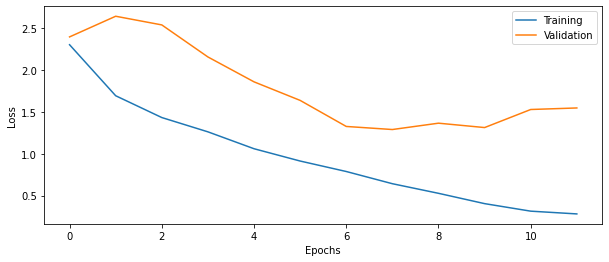

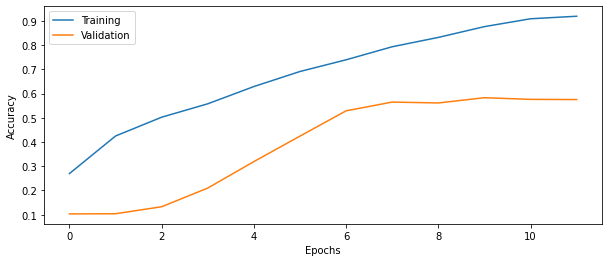

In [150]:
# Plot the history from the training run
plot_results(history5)

##  Part 16: Rotate the test images

How high is the test accuracy if we rotate the test images? In other words, how good is the CNN at generalizing to rotated images?

Rotate each test image 90 degrees, the cells are already finished.

Question 21: What is the test accuracy for rotated test images, compared to test images without rotation? Explain the difference in accuracy.

When rotating the data we force our network to learn more parameters in order to detect what type of object it is. For instance if we supply our model with pictures of rotated dogs, it also must find filters to identify a standing & upside down dog. As such, rotating images increase the demand on our model. Accuracy is as such down with a lot.

In [151]:
def myrotate(images):

    images_rot = np.rot90(images, axes=(1,2))
    
    return images_rot

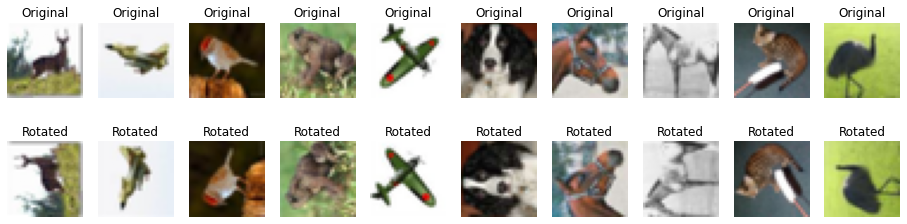

In [152]:
# Rotate the test images 90 degrees
Xtest_rotated = myrotate(Xtest)

# Look at some rotated images
plt.figure(figsize=(16,4))
for i in range(10):
    idx = np.random.randint(500)
    
    plt.subplot(2,10,i+1)
    plt.imshow(Xtest[idx]/2+0.5)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(2,10,i+11)
    plt.imshow(Xtest_rotated[idx]/2+0.5)
    plt.title("Rotated")
    plt.axis('off')
plt.show()


In [153]:
# Evaluate the trained model on rotated test set
score = model5.evaluate(Xtest_rotated, Ytest)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

63/63 [==============================] - 0s 7ms/step - loss: 3.7881 - accuracy: 0.2160
Test loss: 3.7881
Test accuracy: 0.2160


##  Part 17: Augmentation using Keras `ImageDataGenerator`

We can increase the number of training images through data augmentation (we now ignore that CIFAR10 actually has 60 000 training images). Image augmentation is about creating similar images, by performing operations such as rotation, scaling, elastic deformations and flipping of existing images. This will prevent overfitting, especially if all the training images are in a certain orientation.

We will perform the augmentation on the fly, using a built-in function in Keras, called `ImageDataGenerator`

See https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator , the .flow(x,y) functionality

In [154]:
# Get all 60 000 training images again. ImageDataGenerator manages validation data on its own
(Xtrain, Ytrain), _ = cifar10.load_data()

# Reduce number of images to 10,000
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

# Change data type and rescale range
Xtrain = Xtrain.astype('float32')
Xtrain = Xtrain / 127.5 - 1

# Convert labels to hot encoding
Ytrain = to_categorical(Ytrain, 10)

In [155]:
# Set up a data generator with on-the-fly data augmentation, 20% validation split
# Use a rotation range of 30 degrees, horizontal and vertical flipping
from keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(horizontal_flip=True,
    vertical_flip=True, rotation_range = 30, validation_split=0.2)

# Setup a flow for training data, assume that we can fit all images into CPU memory
train_rotate = model5.fit(data_generator.flow(Xtrain, Ytrain, batch_size=batch_size, subset='training'),
                         validation_data=data_generator.flow(Xtrain, Ytrain, batch_size=batch_size, subset='validation'),
                         epochs=epochs)

# Setup a flow for validation data, assume that we can fit all images into CPU memory


Epoch 1/12
73/73 [==============================] - 6s 72ms/step - loss: 2.0887 - accuracy: 0.3868 - val_loss: 2.1933 - val_accuracy: 0.3905
Epoch 2/12
73/73 [==============================] - 5s 64ms/step - loss: 1.5621 - accuracy: 0.4572 - val_loss: 1.4495 - val_accuracy: 0.4945
Epoch 3/12
73/73 [==============================] - 5s 68ms/step - loss: 1.4461 - accuracy: 0.4931 - val_loss: 1.3686 - val_accuracy: 0.5205
Epoch 4/12
73/73 [==============================] - 5s 70ms/step - loss: 1.3961 - accuracy: 0.5086 - val_loss: 1.3228 - val_accuracy: 0.5285
Epoch 5/12
73/73 [==============================] - 5s 70ms/step - loss: 1.3380 - accuracy: 0.5289 - val_loss: 1.2656 - val_accuracy: 0.5535
Epoch 6/12
73/73 [==============================] - 6s 77ms/step - loss: 1.2901 - accuracy: 0.5533 - val_loss: 1.3187 - val_accuracy: 0.5360
Epoch 7/12
73/73 [==============================] - 5s 71ms/step - loss: 1.2514 - accuracy: 0.5573 - val_loss: 1.2512 - val_accuracy: 0.5400
Epoch 8/12
73

## Part 18: What about big data?

Question 22: How would you change the code for the image generator if you cannot fit all training images in CPU memory? What is the disadvantage of doing that change?

Then we need to stream from the network or the harddrive which we can use 

data_generator.flow_from_directory()

Disadvantage is that it's a slower process as we have to stream the data, process it and instead of just processing whatevers in the CPU.

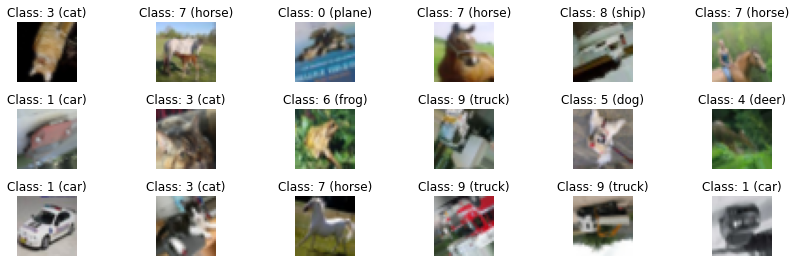

In [156]:
# Plot some augmented images
plot_datagen = data_generator.flow(Xtrain, Ytrain, batch_size=1)

plt.figure(figsize=(12,4))
for i in range(18):
    (im, label) = plot_datagen.next()
    im = (im[0] + 1) * 127.5
    im = im.astype('int')
    label = np.flatnonzero(label)[0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

## Part 19: Train the CNN with images from the generator

See https://keras.io/api/models/model_training_apis/#fit-method for how to use model.fit with a generator instead of a fix dataset (numpy arrays)

To make the comparison fair to training without augmentation

    steps_per_epoch should be set to: len(Xtrain)*(1 - validation_split)/batch_size

    validation_steps should be set to: len(Xtrain)*validation_split/batch_size

Question 23: How quickly is the training accuracy increasing compared to without augmentation? Explain why there is a difference compared to without augmentation. What parameter is necessary to change to perform more training?

Question 24: What other types of image augmentation can be applied, compared to what we use here?

Q23: It's slower, which makes sense if we think about how we now add features which we want our model to able to identify. The number of epochs.

Q24: One could augment the dimensions in some ways, for instance we could make the tyres of a car unproportionally large. Even after altering dimensions like this would humans would still be able to work it out. Other augmentation include channel shifting, zooming in/out, changing brightness, rescaling etc.

In [157]:
# Setup some training parameters
batch_size = 100
epochs = 200
input_shape = Xtrain.shape[1:]

# Build model (your best config)
model6 = build_CNN(input_shape, n_dense_layers=1, n_conv_layers=5, use_dropout=True, learning_rate=0.03)

validation_split=0.2
validation_steps=len(Xtrain)*validation_split/batch_size

steps_per_epoch=len(Xtrain)*(1-validation_split)/batch_size

# Train the model using on the fly augmentation
history6 = model6.fit(data_generator.flow(Xtrain, Ytrain, batch_size=batch_size, subset='training'),
                      validation_data=data_generator.flow(Xtrain, Ytrain, batch_size=batch_size, subset='validation'), 
                      epochs=epochs, batch_size = batch_size, steps_per_epoch=steps_per_epoch,
                     validation_steps=validation_steps, )

Epoch 1/200
80/80 [==============================] - 6s 70ms/step - loss: 2.4033 - accuracy: 0.2405 - val_loss: 2.4548 - val_accuracy: 0.1085
Epoch 2/200
80/80 [==============================] - 5s 63ms/step - loss: 1.9336 - accuracy: 0.3231 - val_loss: 2.6149 - val_accuracy: 0.1900
Epoch 3/200
80/80 [==============================] - 5s 61ms/step - loss: 1.7939 - accuracy: 0.3571 - val_loss: 2.5451 - val_accuracy: 0.1980
Epoch 4/200
80/80 [==============================] - 5s 66ms/step - loss: 1.6876 - accuracy: 0.3916 - val_loss: 2.1866 - val_accuracy: 0.2390
Epoch 5/200
80/80 [==============================] - 5s 57ms/step - loss: 1.5940 - accuracy: 0.4246 - val_loss: 1.9539 - val_accuracy: 0.2975
Epoch 6/200
80/80 [==============================] - 6s 71ms/step - loss: 1.5303 - accuracy: 0.4453 - val_loss: 1.6498 - val_accuracy: 0.4240
Epoch 7/200
80/80 [==============================] - 6s 78ms/step - loss: 1.4802 - accuracy: 0.4606 - val_loss: 1.4442 - val_accuracy: 0.4790
Epoch 

80/80 [==============================] - 5s 65ms/step - loss: 0.6945 - accuracy: 0.7607 - val_loss: 1.2001 - val_accuracy: 0.6265
Epoch 59/200
80/80 [==============================] - 5s 62ms/step - loss: 0.7010 - accuracy: 0.7616 - val_loss: 1.1951 - val_accuracy: 0.6010
Epoch 60/200
80/80 [==============================] - 5s 62ms/step - loss: 0.6756 - accuracy: 0.7679 - val_loss: 1.3185 - val_accuracy: 0.5910
Epoch 61/200
80/80 [==============================] - 5s 64ms/step - loss: 0.6804 - accuracy: 0.7616 - val_loss: 1.2594 - val_accuracy: 0.6215
Epoch 62/200
80/80 [==============================] - 5s 67ms/step - loss: 0.6797 - accuracy: 0.7694 - val_loss: 1.1823 - val_accuracy: 0.6225
Epoch 63/200
80/80 [==============================] - 5s 67ms/step - loss: 0.6647 - accuracy: 0.7714 - val_loss: 1.3098 - val_accuracy: 0.6020
Epoch 64/200
80/80 [==============================] - 5s 65ms/step - loss: 0.6644 - accuracy: 0.7732 - val_loss: 1.2062 - val_accuracy: 0.6235
Epoch 65/200

80/80 [==============================] - 6s 75ms/step - loss: 0.3817 - accuracy: 0.8746 - val_loss: 1.4286 - val_accuracy: 0.6360
Epoch 116/200
80/80 [==============================] - 6s 69ms/step - loss: 0.3790 - accuracy: 0.8698 - val_loss: 1.4233 - val_accuracy: 0.6305
Epoch 117/200
80/80 [==============================] - 5s 65ms/step - loss: 0.3679 - accuracy: 0.8766 - val_loss: 1.5402 - val_accuracy: 0.6025
Epoch 118/200
80/80 [==============================] - 5s 65ms/step - loss: 0.3755 - accuracy: 0.8771 - val_loss: 1.4500 - val_accuracy: 0.6190
Epoch 119/200
80/80 [==============================] - 5s 66ms/step - loss: 0.3563 - accuracy: 0.8811 - val_loss: 1.4429 - val_accuracy: 0.6370
Epoch 120/200
80/80 [==============================] - 5s 68ms/step - loss: 0.3282 - accuracy: 0.8894 - val_loss: 1.4883 - val_accuracy: 0.6325
Epoch 121/200
80/80 [==============================] - 5s 63ms/step - loss: 0.3810 - accuracy: 0.8701 - val_loss: 1.4553 - val_accuracy: 0.6280
Epoch 

Epoch 172/200
80/80 [==============================] - 5s 63ms/step - loss: 0.2349 - accuracy: 0.9243 - val_loss: 1.6754 - val_accuracy: 0.6295
Epoch 173/200
80/80 [==============================] - 5s 68ms/step - loss: 0.2509 - accuracy: 0.9180 - val_loss: 1.6897 - val_accuracy: 0.6440
Epoch 174/200
80/80 [==============================] - 5s 67ms/step - loss: 0.2462 - accuracy: 0.9181 - val_loss: 1.6373 - val_accuracy: 0.6310
Epoch 175/200
80/80 [==============================] - 5s 63ms/step - loss: 0.2253 - accuracy: 0.9224 - val_loss: 1.7125 - val_accuracy: 0.6290
Epoch 176/200
80/80 [==============================] - 5s 64ms/step - loss: 0.2598 - accuracy: 0.9169 - val_loss: 1.6234 - val_accuracy: 0.6260
Epoch 177/200
80/80 [==============================] - 5s 61ms/step - loss: 0.2555 - accuracy: 0.9176 - val_loss: 1.6401 - val_accuracy: 0.6335
Epoch 178/200
80/80 [==============================] - 5s 65ms/step - loss: 0.2236 - accuracy: 0.9264 - val_loss: 1.7016 - val_accuracy:

In [158]:
# Check if there is still a big difference in accuracy for original and rotated test images

# Evaluate the trained model on original test set
score = model6.evaluate(Xtest, Ytest, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

# Evaluate the trained model on rotated test set
score = model6.evaluate(Xtest_rotated, Ytest, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 1.7747
Test accuracy: 0.6440
Test loss: 4.0790
Test accuracy: 0.3110


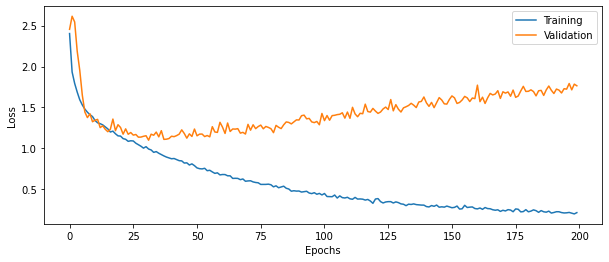

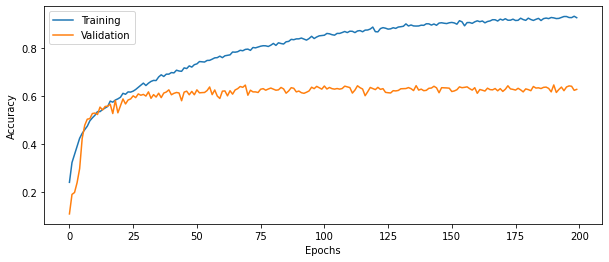

In [159]:
# Plot the history from the training run
plot_results(history6)

## Part 20: Plot misclassified images

Lets plot some images where the CNN performed badly, these cells are already finished.

In [160]:
# Find misclassified images
y_pred=model6.predict(Xtest) 
y_pred=np.argmax(y_pred,axis=1)

y_correct = np.argmax(Ytest,axis=-1)

miss = np.flatnonzero(y_correct != y_pred)

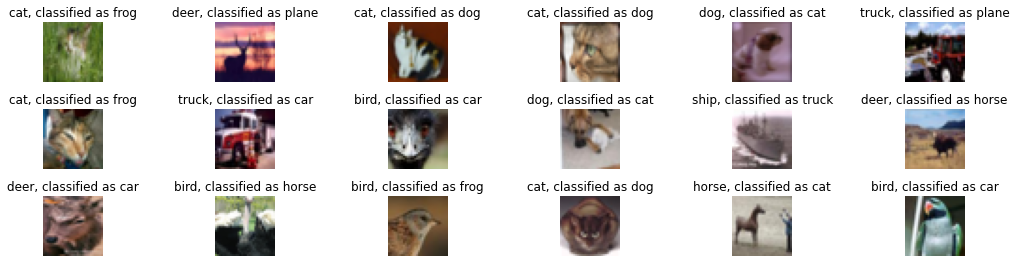

In [161]:
# Plot a few of them
plt.figure(figsize=(15,4))
perm = np.random.permutation(miss)
for i in range(18):
    im = (Xtest[perm[i]] + 1) * 127.5
    im = im.astype('int')
    label_correct = y_correct[perm[i]]
    label_pred = y_pred[perm[i]]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.axis('off')
    plt.title("{}, classified as {}".format(classes[label_correct], classes[label_pred]))
plt.show()

##  Part 21: Testing on another size

Question 25: This CNN has been trained on 32 x 32 images, can it be applied to images of another size? If not, why is this the case?

Question 26: Is it possible to design a CNN that can be trained on images of one size, and then applied to an image of any size? How?

Q25: No not directly, as we need to know the input shape when defining our architecture. It is therefor necessary to convert all images to have the same size - and that we know this size when creating our network.

Q26: Yes you can, by either resizing the images to the size of the smallest image or by padding the images of unequal size to whatever size we desire our network to have.

##  Part 22: Pre-trained 2D CNNs

There are many deep 2D CNNs that have been pre-trained using the large ImageNet database (several million images, 1000 classes). Import a pre-trained ResNet50 network from Keras applications. Show the network using `model.summary()`

Question 27: How many convolutional layers does ResNet50 have? 

Question 28: How many trainable parameters does the ResNet50 network have? 

Question 29: What is the size of the images that ResNet50 expects as input?

Question 30: Using the answer to question 28, explain why the second derivative is seldom used when training deep networks.

Apply the pre-trained CNN to 5 random color images that you download and copy to the cloud machine or your own computer. Are the predictions correct? How certain is the network of each image class?

These pre-trained networks can be fine tuned to your specific data, and normally only the last layers need to be re-trained, but it will still be too time consuming to do in this laboration.

See https://keras.io/api/applications/ and https://keras.io/api/applications/resnet/#resnet50-function 

Useful functions

`image.load_img` in tensorflow.keras.preprocessing

`image.img_to_array` in tensorflow.keras.preprocessing

`ResNet50` in tensorflow.keras.applications.resnet50

`preprocess_input` in tensorflow.keras.applications.resnet50

`decode_predictions` in tensorflow.keras.applications.resnet50

`expand_dims` in numpy


Q27: 48 Convolution layers.

Q28: 25.6M

Q29: 224x224

Q30: Because of the computational cost of such a large hessian matrix is to large.

Yes the network is correct in 4/5 cases I'd say, it did a main prediction of goose when it was a swan. The certainty for each class is printed below.

In [162]:
# Your code for using pre-trained ResNet 50 on 5 color images of your choice. 
# The preprocessing should transform the image to a size that is expected by the CNN.
from tensorflow.keras.applications.resnet50  import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

model = ResNet50(weights='imagenet')
img_path = ['dog.jpg', 'bird.jpg', 'bike.jpg', 'car.jpg', 'girl.jpg']
for i in range(0, 5):
    img = image.load_img(img_path[i], target_size=(224, 224))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)

    print('Predicted:', decode_predictions(preds, top=3)[0][0], "\n")

Predicted: ('n02102318', 'cocker_spaniel', 0.38863856) 

Predicted: ('n01855672', 'goose', 0.60254455) 

Predicted: ('n02835271', 'bicycle-built-for-two', 0.8809378) 

Predicted: ('n04037443', 'racer', 0.45546517) 

Predicted: ('n03404251', 'fur_coat', 0.90279824) 

